### ESM-3: toy optimization problem.
- two generators, single load, single bus
- multiple time periods
- a storage device
- a discussion of storage dispatch, and the impact on the system
- (start of) a discussion about model VS reality juxtaposition

In [164]:
### Problem formulation
# generator 1: "gas" (CCGT), marginal cost 70 EUR/MWh, capacity 50 MW
# generator 2: "coal" (hard coal), marginal cost 40 EUR/MWh, capacity 100 MW
# load: "UA" (Ukraine), 120 MW
# multiple time steps
# storage device: "battery", capacity 100 MWh, charging efficiency 0.9, discharging efficiency 0.9

In [165]:
import pypsa
import numpy as np
import pandas as pd
import linopy
import matplotlib.pyplot as plt

### Create PyPSA network with components of the problem

In [166]:
n = pypsa.Network()

In [167]:
n.add("Bus", "UA", v_nom=380)
n.add(
    "Generator",
    "gas",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "coal",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=40,  # €/MWh
    p_nom=100,  # MW
)

In [168]:
n.snapshots = pd.date_range("2019-01-01", periods=5, freq="H")
load_series = pd.Series([80, 90, 110, 120, 100], index=n.snapshots)

In [169]:
n.add(
    "Load",
    "Ukraine",
    bus="UA",
    p_set=load_series,  # MW
)

In [170]:
n.loads_t.p_set

Load,Ukraine
snapshot,
2019-01-01 00:00:00,80.0
2019-01-01 01:00:00,90.0
2019-01-01 02:00:00,110.0
2019-01-01 03:00:00,120.0
2019-01-01 04:00:00,100.0


## Solve with PyPSA optimize module w/o storage

In [171]:
# n.optimize.create_model()

In [172]:
n.optimize(solver_name="glpk")

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-w09iyigo.lp --output /tmp/linopy-solve-8mxs7i33.sol
Reading problem data from '/tmp/linopy-problem-w09iyigo.lp'...
25 rows, 10 columns, 30 non-zeros
135 lines were read
GLPK Simplex Optimizer 5.0
25 rows, 10 columns, 30 non-zeros
Preprocessing...
~     0: obj =   2.090000000e+04  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.0 Mb (39693 bytes)
Writing basic solution to '/tmp/linopy-solve-8mxs7i33.sol'...


('ok', 'optimal')

In [173]:
n.objective

20900.0

In [174]:
n.generators_t.p

Generator,gas,coal
snapshot,,
2019-01-01 00:00:00,0.0,80.0
2019-01-01 01:00:00,0.0,90.0
2019-01-01 02:00:00,10.0,100.0
2019-01-01 03:00:00,20.0,100.0
2019-01-01 04:00:00,0.0,100.0


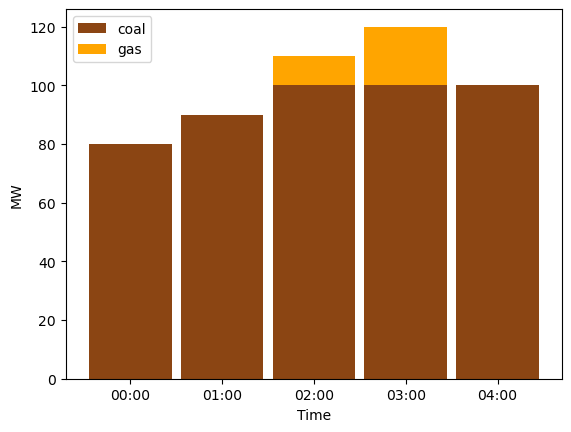

In [175]:
def plot_dispatch(n):
    df = n.generators_t.p
    colors = {"coal": "#8B4513", "gas": "#FFA500"}
    df = df[["coal", "gas"]]
    df.plot(kind="bar", stacked=True, width=0.9, color=[colors[c] for c in df.columns])
    plt.xticks(np.arange(len(df.index)), df.index.strftime("%H:%M"))
    plt.xticks(rotation=0)
    plt.xlabel("Time")
    plt.ylabel("MW")
    plt.legend(loc="upper left")
    plt.show()


plot_dispatch(n)

### Retrieve electricity prices w/o storage

In [176]:
n.model.dual

<xarray.Dataset>
Dimensions:                (snapshot: 5, Generator-fix: 2, Bus: 1)
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2019-01-01 ... 2019-01-0...
  * Generator-fix          (Generator-fix) object 'gas' 'coal'
  * Bus                    (Bus) object 'UA'
Data variables:
    Generator-fix-p-lower  (snapshot, Generator-fix) float64 30.0 0.0 ... 0.0
    Generator-fix-p-upper  (snapshot, Generator-fix) float64 0.0 0.0 ... 0.0 0.0
    Bus-nodal_balance      (snapshot, Bus) float64 40.0 40.0 70.0 70.0 40.0

<Axes: xlabel='snapshot'>

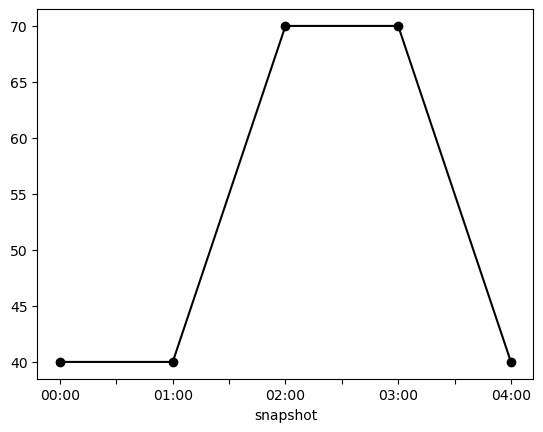

In [177]:
prices = n.model.dual["Bus-nodal_balance"].values
series = pd.Series([item[0] for item in prices], index=n.snapshots.strftime("%H:%M"))
series.plot(marker="o", linestyle="-", color="black")

## Solve with PyPSA optimize module with storage device

### Add battery storage

In [178]:
# see documentation: https://pypsa.readthedocs.io/en/latest/components.html#storage-unit

n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=20,  # MW
    max_hours=5,  # 20 MW * 5 hours = 100 MWh
    efficiency_store=0.9,
    efficiency_dispatch=0.9,
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

In [179]:
n.storage_units.T

StorageUnit,Battery
attribute,
bus,UA
control,PQ
type,
p_nom,20.0
p_nom_mod,0.0
p_nom_extendable,False
p_nom_min,0.0
p_nom_max,inf
p_min_pu,-1.0


### Solve the problem with storage and revise results

In [180]:
# See documentation of storage unit equations: https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html#storage-unit-constraints

In [ ]:
# ensure that the new variables and equations are added to the model
n.optimize.create_model()

In [182]:
n.optimize(solver_name="glpk")

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-_57brhuk.lp --output /tmp/linopy-solve-jsa_ebr4.sol
Reading problem data from '/tmp/linopy-problem-_57brhuk.lp'...
60 rows, 25 columns, 89 non-zeros
307 lines were read
GLPK Simplex Optimizer 5.0
60 rows, 25 columns, 89 non-zeros
Preprocessing...
9 rows, 17 columns, 29 non-zeros
Scaling...
 A: min|aij| =  9.000e-01  max|aij| =  1.111e+00  ratio =  1.235e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 9
      0: obj =   3.260000000e+04 inf =   2.200e+02 (4)
      5: obj =   2.600000000e+04 inf =   0.000e+00 (0)
*    15: obj =   2.039900000e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (56560 bytes)
Writing basic solution to '/tmp/linopy-solve-jsa_ebr4.sol'...


('ok', 'optimal')

In [183]:
# notice that objective value is now lower. Why?
n.objective

20399.0

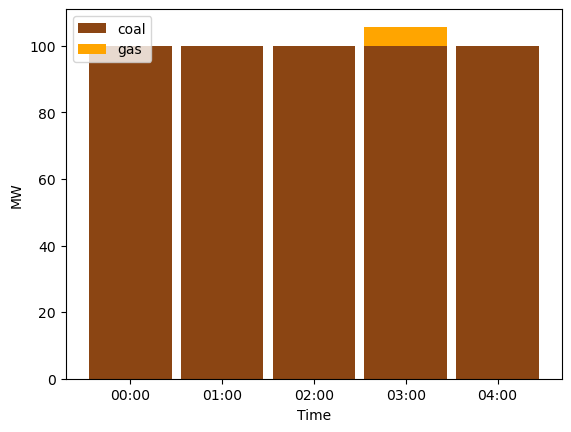

In [184]:
# let's plot the dispatch again
plot_dispatch(n)

<Axes: xlabel='snapshot'>

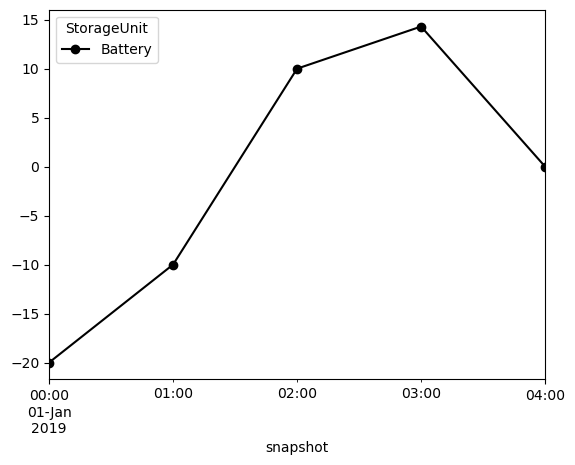

In [185]:
# let's take a look at the storage unit variables
# First, dispatch (negative means charging, positive means discharging)
n.storage_units_t.p.plot(marker="o", linestyle="-", color="black")

<Axes: xlabel='snapshot'>

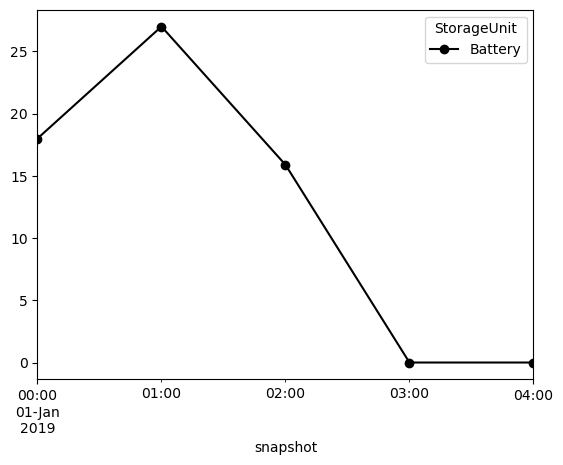

In [186]:
# let's take a look at the storage unit variables
# Second, state of charge
n.storage_units_t.state_of_charge.plot(marker="o", linestyle="-", color="black")

In [187]:
# you can also retrive time-series of all electrical components' dispatch located in a specific bus:
n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False).loc[
    :, :, "AC", "UA"
]

,snapshot,2019-01-01 00:00:00,2019-01-01 01:00:00,2019-01-01 02:00:00,2019-01-01 03:00:00,2019-01-01 04:00:00
component,carrier,,,,,
Generator,-,100.0,100.0,100.0,105.7,100.0
Load,-,-80.0,-90.0,-110.0,-120.0,-100.0
StorageUnit,-,-20.0,-10.0,10.0,14.3,0.0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


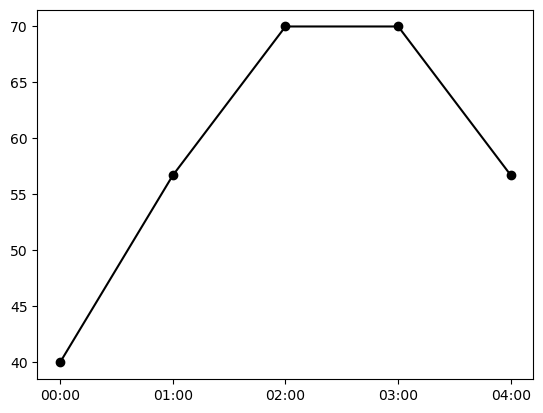

In [188]:
# Let's explore how storage dispatch affects prices. Where from do we get the "intermediate" price level?
prices = n.model.dual["Bus-nodal_balance"].values
series = pd.Series([item[0] for item in prices], index=n.snapshots.strftime("%H:%M"))
plt.plot(series.index, series.values, marker="o", linestyle="-", color="black")